### Changing the World with Airbnb  - Data Exploration
#### Patrick Huston | Spring 2016

This notebook aims to explore the dataset made public by Airbnb - a dataset that includes listings, reviews, and calendars of listing availabilities for a whole host of major world cities. In this exploration, I'll be looking mostly at the SF and Boston datasets.

#### Thoughts for Exploration and CTW Aspect

##### Questions we would like to tackle
 - What is the one amenity that makes your listing more desireable? (**Patrick**)
     - number of reviews vs. number of amenities
     - review score value accuracy, communication - for different amenities offered
     - reviewed value
 - Reviews per month --> host statistics potential analysis - communication score and Review per month 
 - How much does a neighborhood affect the listing's qualities (**Filippos**)
     - bar graphs based on variation of price 
 - What affects price? (**BOTH --> think about future*
     - Seasonality
     - Location (neighborhood, [lat,long])
     - Bio
     - Reviews (their sentiments/scores)
 - Reviews ~ Price ? 
 - Get heatmap of prices and see whether we can detect if there is an affluence (**BOTH**)
 - Heatmap of desireability of location/area --> Let's look into that later 
 - Time Series of bookings and how many bookings there are for different areas
 - Acceptance rate --> how does this affect their profile/ratings + host reliability  (**Filippos**)
 - How does price vary over time (calendar.csv)? Notice any patterns there for different listings? Might have to correlate with the other listings CSV file and derive certain conclusions.
     - normalize variation in price to see how it is affected by time (calendar.csv)
 - What gives us a job at Airbnb? (**BOTH**)


##### Vizualizations
 - Figure out library to use
     - Seaborn --> use for static/non-static **non-map** vizualizations
     - JS libraries for overlaying information on maps and other cool stuff - D3
 - Interactive vs. static
      - Plotly:
          - Not enought reference documentation
          - WebAPI with wrappers - Is it easy to manipulate
      - Seaborn:
          - Seems very static-based
      - Basemap
          - Nothing super interesting about it
 
##### Area/Neighbohood information --> Meta data for the location and context
 - Perhaps use information from other datasets to *assess* the area
 
##### For next time
 - Explore the dataset and produce insights and vizualizations on the questions we found interesting to tackle
 
##### During Tuesday
 - Develop an API for methods to use 
 - Util for reviews --> poll a given if to get all reviews
 
##### Due Friday
 - Model Iteration #1 and formally present findings on 
 

#### Imports

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns

from decimal import Decimal

/home/patrick/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#### Loading the Data

The data is available publically on [Airbnb's website](http://insideairbnb.com/get-the-data.html) as a csv.

In [3]:
listingsBoston = pd.read_csv('./data/listingsBoston.csv')
listingsSF = pd.read_csv('./data/listingsSF.csv')
listingsLA = pd.read_csv('./data/listingsLA.csv')
listingsDC = pd.read_csv('./data/listingsDC.csv')
listingsSeattle = pd.read_csv('./data/listingsSeattle.csv')

frames = [listingsBoston, listingsSF, listingsLA, listingsDC, listingsSeattle]

listings = pd.concat(frames)

# listings = listings.dropna(subset=['weekly_price'])

/home/patrick/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
calendarBoston = pd.read_csv('./data/calendarBoston.csv')

calendarBoston = calendarBoston[calendarBoston.available == 't']

There are tons of features in this dataset - some of them seem like they might be useful, others not as much. To begin with, I'll create a list of the feature names that I intuitively think might be useful/interesting to explore.

In [7]:
for feature in listings.columns:
    print "- " + feature

features = ['id', 'name', 'summary', 'space', 'neighborhood_overview', 'notes', 
            'transit', 'host_id', 'host_name', 'host_since', 'host_location', 
            'host_about', 'host_response_time', 'host_acceptance_rate', 'host_is_superhost',
            'host_listings_count', 'host_verifications', 'host_has_profile_pic',
            'host_identity_verified', 'street', 'neighbourhood', 'city', 'state', 
            'zipcode', 'market', 'country_code', 'country', 'latitude', 'longitude',
            'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
            'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price',
            'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
            'minimum_nights', 'maximum_nights', 'calendar_updated', 'has_availability',
            'availability_30', 'availability_60', 'availability_90', 'availability_90',
            'availability_365', 'number_of_reviews', 'first_review', 'last_review',
            'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
            'review_scores_communication', 'review_scores_location', 'review_scores_value',
            'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification',
            'calculated_host_listings_count', 'reviews_per_month']

listings = listings[features]

# listings.describe()

- id
- name
- summary
- space
- neighborhood_overview
- notes
- transit
- host_id
- host_name
- host_since
- host_location
- host_about
- host_response_time
- host_acceptance_rate
- host_is_superhost
- host_listings_count
- host_verifications
- host_has_profile_pic
- host_identity_verified
- street
- neighbourhood
- city
- state
- zipcode
- market
- country_code
- country
- latitude
- longitude
- room_type
- accommodates
- bathrooms
- bedrooms
- beds
- bed_type
- amenities
- square_feet
- price
- weekly_price
- monthly_price
- security_deposit
- cleaning_fee
- guests_included
- extra_people
- minimum_nights
- maximum_nights
- calendar_updated
- has_availability
- availability_30
- availability_60
- availability_90
- availability_90
- availability_90
- availability_90
- availability_365
- number_of_reviews
- first_review
- last_review
- review_scores_rating
- review_scores_accuracy
- review_scores_cleanliness
- review_scores_communication
- review_scores_location
- review_scores_value
-

#### Data Cleaning
While we're at it, let's also define a data cleaning function to process the data automatically.

In [98]:
# Function to parse amenities from str format into list
def amenities_to_list(amenities):
    amenities = amenities.replace('{', '')
    amenities = amenities.replace('}', '')
    amenities = amenities.replace('\"', '')
    return amenities.split(',')

# Get number of amenities
def num_amenities(amenitiesList):
    return len(amenitiesList)

# Turn string dollars into decimals
def price_to_int(price):
    price = price.replace(',', '')
    price = price.replace('$', '')
    return float(price)

# Applies all cleaning functions
def clean_listings(df):
    df_clean = df.copy()
    df_clean['amenities'] = df_clean['amenities'].apply(amenities_to_list)
    df_clean['num_amenities'] = df_clean['amenities'].apply(num_amenities)
    df_clean['price'] = df_clean['price'].apply(price_to_int)
    
    df_clean.loc[df_clean.review_scores_rating.isnull(), 'review_scores_rating'] = 90

    return df_clean

def clean_calendar(df):
    df_clean = df.copy()
    df_clean['price'] = df_clean['price'].apply(price_to_int)

    return df_clean

In [100]:
listingsClean = clean_listings(listings)

print listingsClean['price'][0]

print listingsClean['amenities'][0]
print listingsClean['num_amenities'][0]

0     62
0    350
0    150
0    160
0     85
Name: price, dtype: float64
0    [TV, Cable TV, Internet, Wireless Internet, Ai...
0    [TV, Cable TV, Internet, Wireless Internet, Ki...
0    [Cable TV, Wireless Internet, Kitchen, Pets li...
0    [TV, Wireless Internet, Air Conditioning, Kitc...
0    [TV, Cable TV, Internet, Wireless Internet, Ai...
Name: amenities, dtype: object
0    17
0     9
0     7
0    14
0    10
Name: num_amenities, dtype: int64


In [85]:
calendarClean = clean_calendar(calendarBoston)

Now that we have all of the more interesting features in one dataframe, let's get a sense for how the data is distributed. Immediately, it becomes clear that there's not much data available - if our final goal is to produce some predictive model, we're going to want much more than 2558 listings. For now, we'll stick with this, but that's something to keep in mind. Another interesting facet of the data is how high reviews are. I'm wondering if Airbnb inflates ratings or whether all Airbnb listings are really this good - in either case, it is in Airbnb's best interest for ratings to be higher, as people will be more likely to use the service.

In [86]:
listingsClean.describe()

,id,host_id,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,num_amenities
count,37690.000000,37690.000000,37683.000000,37690.000000,37690.000000,37690.000000,37423.000000,37606.000000,37599.000000,939.000000,...,37690.000000,37690.000000,28212.000000,28261.000000,28288.000000,28237.000000,28235.000000,37690.000000,28770.000000,37690.000000
mean,5375879.803104,16206661.592306,7.595096,37.163478,-112.223178,3.207535,1.302969,1.294421,1.718024,967.680511,...,16.514036,72.947015,9.544804,9.355048,9.736531,9.485816,9.329201,2.865402,1.783400,13.934067
std,2978103.687812,14738506.127815,38.812362,4.309421,16.956106,2.138053,0.701128,0.886966,1.287541,891.504777,...,30.917784,36.824510,0.832597,1.005918,0.678945,0.825546,0.878604,5.609324,1.734202,5.002276
min,109.000000,42.000000,1.000000,33.705835,-122.513065,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,10.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.010000,1.000000
25%,2823531.750000,3551340.750000,1.000000,34.060379,-122.320423,2.000000,1.000000,1.000000,1.000000,400.000000,...,1.000000,40.000000,9.000000,9.000000,10.000000,9.000000,9.000000,1.000000,0.530000,11.000000
50%,5772956.500000,10979943.000000,1.000000,34.157119,-118.385000,2.000000,1.000000,1.000000,1.000000,800.000000,...,4.000000,93.000000,10.000000,10.000000,10.000000,10.000000,9.000000,1.000000,1.140000,14.000000
75%,7937694.500000,26805642.500000,3.000000,38.897171,-118.245183,4.000000,1.500000,1.000000,2.000000,1200.000000,...,18.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,2.500000,17.000000
max,10340165.000000,53208610.000000,847.000000,47.733358,-70.987107,16.000000,8.000000,10.000000,16.000000,7000.000000,...,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,70.000000,13.870000,35.000000


In [95]:
def plot_distribution(df, col):
    plt.figure(figsize=(12,6))
    sns.set_context("talk")
    sns.distplot(df[col])
    
    sns.plt.title('Distribution of {}'.format(col))
    sns.plt.xlabel('{}'.format(col))
    sns.plt.ylabel('Count')
    
    sns.plt.show()

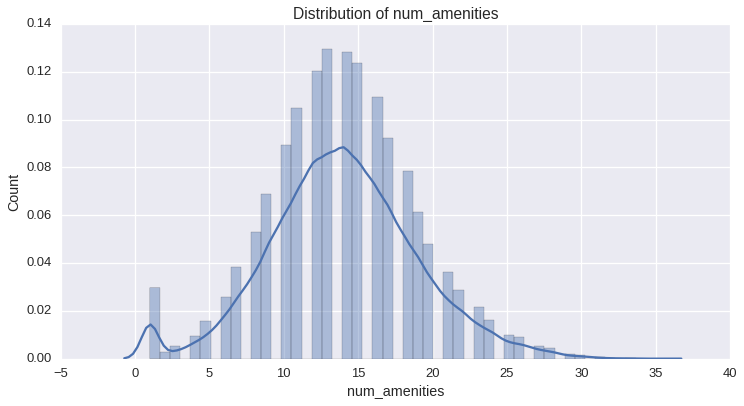

In [88]:
plot_distribution(listingsClean, 'num_amenities')

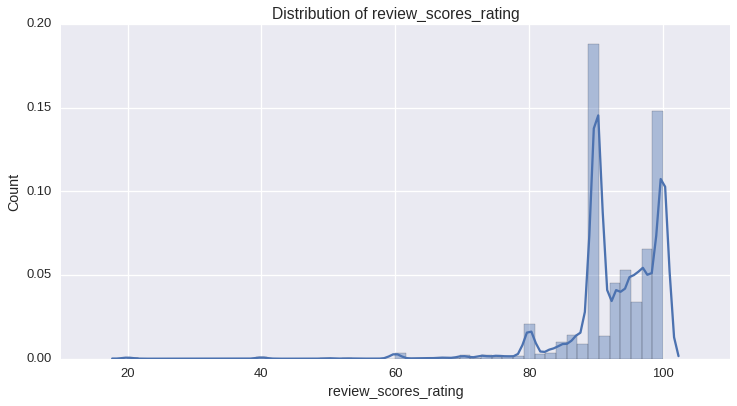

In [101]:
plot_distribution(listingsClean, 'review_scores_rating')

In [92]:
bad = listingsClean[listingsClean['review_scores_rating'] < 50]

print bad

            id                                 name  \
20     3420384       Convient, Safe and Comfortable   
21     8473851   Private Room in Single Family Home   
31     7858329         Charming abode in Roslindale   
51     7929693      Excellent Room in Jamiaca Plain   
61     8354938  Egleston Sq JP luxury 2bd w/parking   
62     1301500   Cozy guest room in the heart of JP   
68     5904596        Trendy JP Condo, Steps from T   
72     6862594  Beautiful Home in Jamaica Plain, MA   
82     8336364               Beautiful Modern Condo   
87     6386351  Charming Arboretum Area 1+ Bed/1 Ba   
106    8481291           Beautiful, airy room in JP   
128    7790454                      Vacation Rental   
129    8310894              1 Bedroom Jamaica Plain   
143    2828426   Sunny Apartment in the Heart of JP   
147    7602111         Pondside Condo- monthly only   
156    7554801   Cozy guest room. Awesome location!   
160    5450017  Cosy nook getaway in JP close to T    
167    629

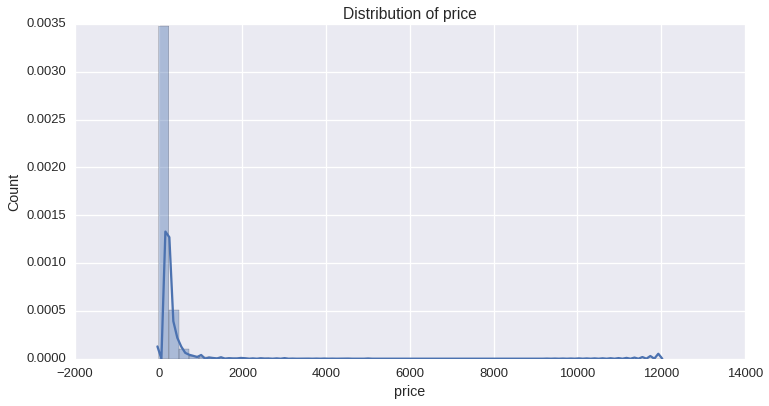

In [59]:
plot_distribution(listingsClean, 'price')

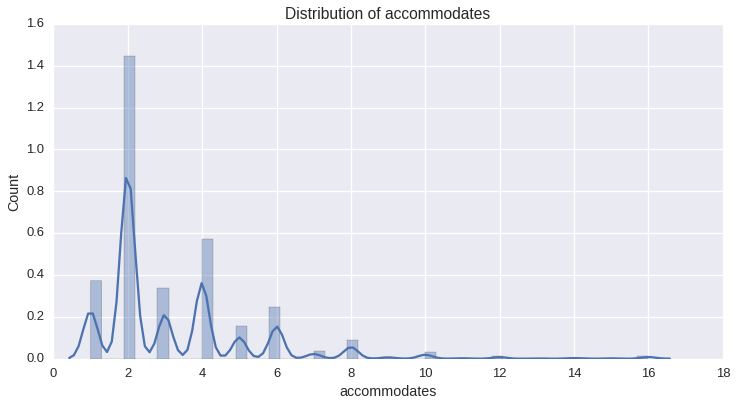

In [60]:
plot_distribution(listingsClean, 'accommodates')

In [22]:
# Helper function to make plots investigating correlation between different features
def explore_correlation(df, col1, col2):
    plt.figure(figsize=(10,6))
    sns.set_context("talk")
    
    sns.regplot(df[col1], df[col2])
    
    sns.plt.title('{} vs. {}'.format(col1, col2))
    sns.plt.xlabel(col1)
    sns.plt.ylabel(col2)
    
    sns.plt.show()

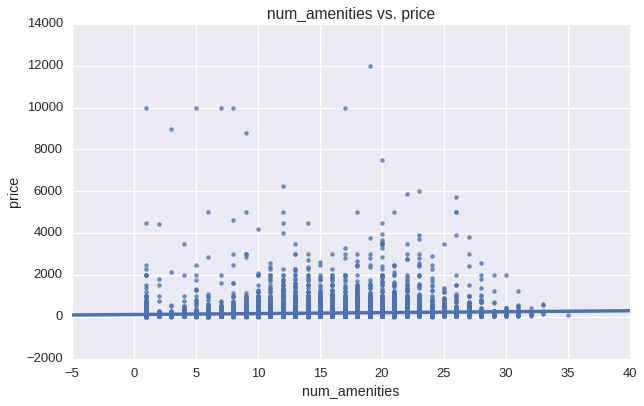

In [63]:
explore_correlation(listingsClean, 'num_amenities', 'price')

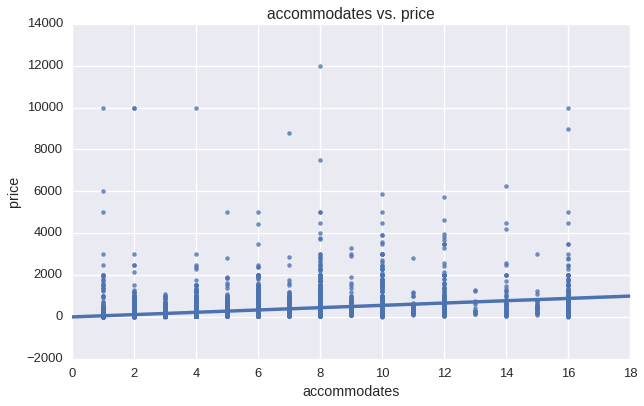

In [32]:
explore_correlation(listingsClean, 'accommodates', 'price')

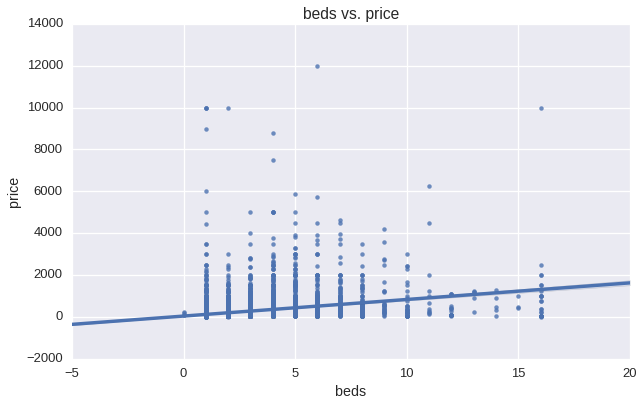

In [33]:
explore_correlation(listingsClean, 'beds', 'price')

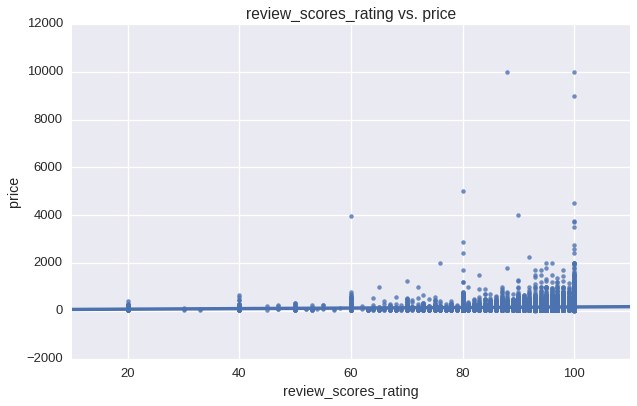

In [34]:
explore_correlation(listingsClean, 'review_scores_rating', 'price')

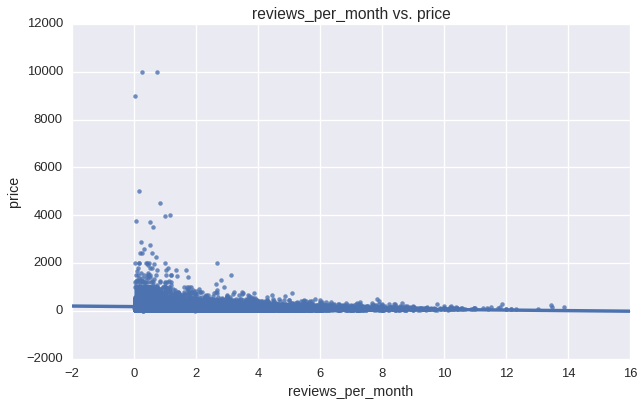

In [35]:
explore_correlation(listingsClean, 'reviews_per_month', 'price')

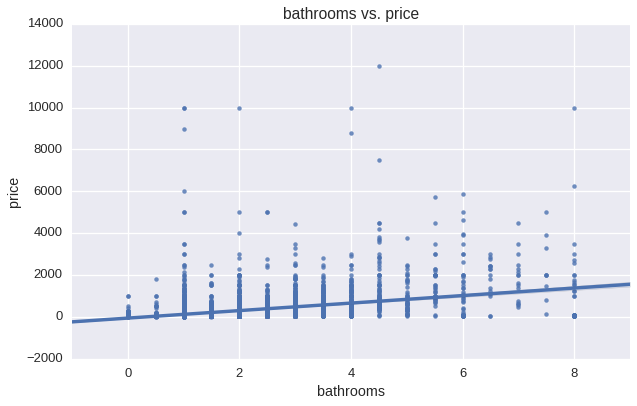

In [36]:
explore_correlation(listingsClean, 'bathrooms', 'price')

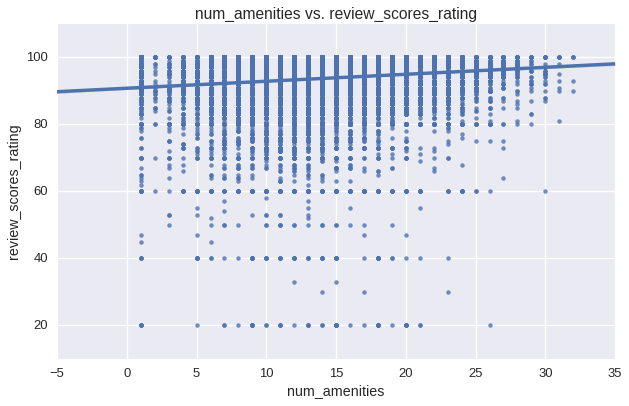

In [29]:
explore_correlation(listingsClean, 'num_amenities', 'review_scores_rating')